In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [4]:
df = pd.read_csv('AirPassengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

In [5]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    Args:
    dataset: A numpy array of time series, first dimension is the time steps
    lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [8]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)


C:\Users\Diae\AppData\Local\Temp\ipykernel_1788\2760436764.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(X), torch.tensor(y)


In [9]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


In [10]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True,batch_size=8)


In [11]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse,test_rmse))
      


C:\Users\Diae\AppData\Local\Temp\ipykernel_1788\1188669340.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
C:\Users\Diae\AppData\Local\Temp\ipykernel_1788\1188669340.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 225.8935, test RMSE 425.1223
Epoch 100: train RMSE 178.0413, test RMSE 374.9400
Epoch 200: train RMSE 141.3440, test RMSE 334.8060
Epoch 300: train RMSE 111.4387, test RMSE 299.2985
Epoch 400: train RMSE 89.4702, test RMSE 268.7638
Epoch 500: train RMSE 68.6316, test RMSE 237.2881
Epoch 600: train RMSE 54.4146, test RMSE 210.3727
Epoch 700: train RMSE 43.8117, test RMSE 186.4967
Epoch 800: train RMSE 36.4440, test RMSE 165.5495
Epoch 900: train RMSE 31.1827, test RMSE 147.3004
Epoch 1000: train RMSE 27.5406, test RMSE 131.7868
Epoch 1100: train RMSE 25.4937, test RMSE 119.9789
Epoch 1200: train RMSE 23.7619, test RMSE 109.1585
Epoch 1300: train RMSE 22.6541, test RMSE 101.9744
Epoch 1400: train RMSE 21.9643, test RMSE 94.8057
Epoch 1500: train RMSE 21.1247, test RMSE 89.6661
Epoch 1600: train RMSE 20.4451, test RMSE 86.0812
Epoch 1700: train RMSE 20.1653, test RMSE 82.3469
Epoch 1800: train RMSE 20.5538, test RMSE 81.5969
Epoch 1900: train RMSE 19.5196, test RMSE 79

In [12]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

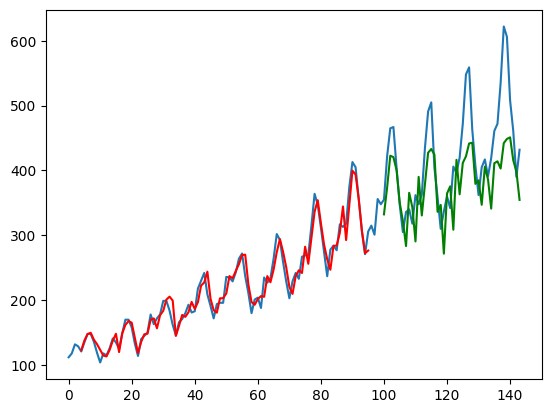

In [13]:
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()
